# Homework notebook for 04-evaluation module

## loading and preparing the data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score



In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [4]:
columns = list(df.columns)
categorical_columns, numerical_columns = [], []
for column in columns:
    if len(df[column].value_counts()) < 20:
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)
print(f"Categorical Columns:\n{categorical_columns}\n\nNumerical columns:\n{numerical_columns}")


Categorical Columns:
['lead_source', 'industry', 'number_of_courses_viewed', 'employment_status', 'location', 'interaction_count', 'converted']

Numerical columns:
['annual_income', 'lead_score']


In [5]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

- filling categorical features with NA and numerical features with 0.0

In [6]:
df[categorical_columns] = df[categorical_columns].fillna("NA")
df[numerical_columns] = df[numerical_columns].fillna(0.0)

df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
for col in ['lead_source', "industry", "employment_status", 'location']:
    print(f"{col}:")
    print(list(df[col].unique()))

lead_source:
['paid_ads', 'social_media', 'events', 'referral', 'organic_search', 'NA']
industry:
['NA', 'retail', 'healthcare', 'education', 'manufacturing', 'technology', 'other', 'finance']
employment_status:
['unemployed', 'employed', 'NA', 'self_employed', 'student']
location:
['south_america', 'australia', 'europe', 'africa', 'middle_east', 'NA', 'north_america', 'asia']


In [8]:

train_val, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=1)
X_train, X_val = train_test_split(train_val, test_size=0.25, shuffle=True, random_state=1)


In [9]:
y_train = X_train.converted.values
y_test = X_test.converted.values
y_val = X_val.converted.values


del X_train['converted']
del X_val['converted']
del X_test['converted']

In [10]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((876, 8), (293, 8), (293, 8), (876,), (293,), (293,))

Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

In [11]:
from sklearn.metrics import roc_auc_score
scores = []
numerical_columns = ['lead_score','number_of_courses_viewed','interaction_count','annual_income']
for col in numerical_columns:
    score = roc_auc_score(y_score=X_train[col], y_true=y_train)
    print(f"ROC AUC for {col}:\n{score}")
    scores.append(score)
print('-'*20)
print(f"the Column with Largest score is: {numerical_columns[np.argmax(scores)]} with score {scores[np.argmax(scores)]:.4f}")

ROC AUC for lead_score:
0.6144993577250176
ROC AUC for number_of_courses_viewed:
0.7635680590007088
ROC AUC for interaction_count:
0.738270176293409
ROC AUC for annual_income:
0.5519578313253012
--------------------
the Column with Largest score is: number_of_courses_viewed with score 0.7636


Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [12]:
dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
dv.fit(train_dict)
X_train_encoded = dv.transform(train_dict)

lr= LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_train_encoded, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
val_dict = X_val.to_dict(orient='records')
X_val_encoded = dv.transform(val_dict)
AUC_score = roc_auc_score(lr.predict(X_val_encoded), y_val)
print(f"ROC AUC score is : {AUC_score:.3f}")

ROC AUC score is : 0.762


Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

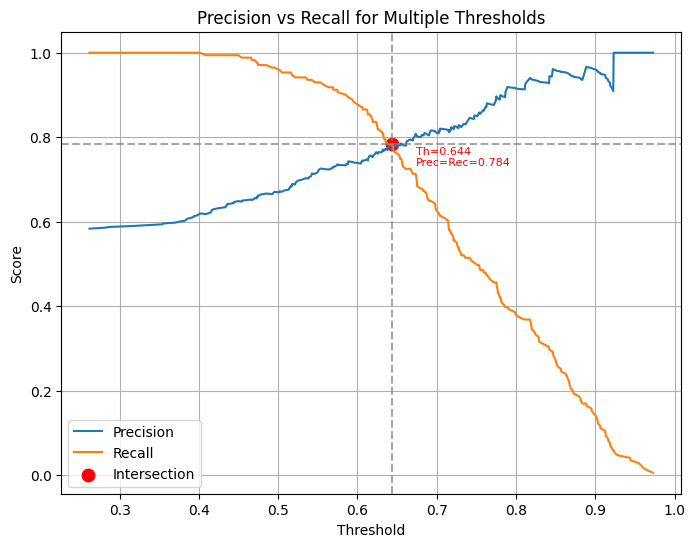

In [14]:
# Compute precision, recall, and thresholds
y_pred_proba = lr.predict_proba(X_val_encoded)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# The last precision and recall values correspond to threshold = 1.0
# But `precision_recall_curve` returns one more value than thresholds
# So we remove the last point to align with threshold length
precision = precision[:-1]
recall = recall[:-1]

# Find where precision and recall intersect
idx = np.argmin(np.abs(precision - recall))

intersection_threshold = thresholds[idx]
intersection_precision = precision[idx]
intersection_recall = recall[idx]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision, label="Precision", color='tab:blue')
plt.plot(thresholds, recall, label="Recall", color='tab:orange')

# Mark intersection
plt.axvline(x=intersection_threshold, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=intersection_recall, color='gray', linestyle='--', alpha=0.7)
plt.scatter(intersection_threshold, intersection_precision, color='red', s=80, label='Intersection')

plt.text(intersection_threshold + 0.03, intersection_precision - 0.03,
         f"Th={intersection_threshold:.3f}\nPrec=Rec={intersection_precision:.3f}",
         color='red', fontsize=8, va='center')

plt.legend()
plt.title("Precision vs Recall for Multiple Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.show()


Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [15]:
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1)
print(f"best F1 score is -> {f1[best_idx]} at Threshold= {thresholds[best_idx]}")

best F1 score is -> 0.8153846153353728 at Threshold= 0.5535908795455893


Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

In [20]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []
for x_train_idx, x_val_idx in kfold.split(train_val):
    x_train = train_val.iloc[x_train_idx]
    x_val = train_val.iloc[x_val_idx]

    y_train = x_train.converted.values
    y_val = x_val.converted.values
    del x_train['converted']
    del x_val['converted']
    dv, model = train(x_train, y_train)
    y_pred = predict(x_val, dv, model)
    auc_scores.append(roc_auc_score(y_val, y_pred))
print(f"standard deviation of across different folds -> {np.std(auc_scores)}")



standard deviation of across different folds -> 0.03580711942905165


Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?



In [25]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
means = []
Cs = [0.000001, 0.001, 1]
for C in Cs:
    auc_scores = []
    for x_train_idx, x_val_idx in kfold.split(train_val):
        x_train = train_val.iloc[x_train_idx]
        x_val = train_val.iloc[x_val_idx]

        y_train = x_train.converted.values
        y_val = x_val.converted.values
        del x_train['converted']
        del x_val['converted']
        dv, model = train(x_train, y_train, C=C)
        y_pred = predict(x_val, dv, model)
        auc_scores.append(roc_auc_score(y_val, y_pred))
    mean = np.mean(auc_scores)
    means.append(mean)
    print(f"C={C} ->\nmean: {round(mean, 3)}  |  std: {round(np.std(auc_scores), 3)}")
print(f"C= {Cs[np.argmax(means)]} has the BEST mean and it equals {round(means[np.argmax(means)], 3)}")


C=1e-06 ->
mean: 0.56  |  std: 0.024
C=0.001 ->
mean: 0.867  |  std: 0.029
C=1 ->
mean: 0.822  |  std: 0.036
C= 0.001 has the BEST mean and it equals 0.867
